<center>
    <h1>Machine Learning and Data Analytics for Industry 4.0 | SS2020</h1>
    <hr>
    <br>
    <div style="margin:0 60px 0px 0">
        <img src="https://www.mad.tf.fau.de/files/2019/04/logo_mad.png" align=center width=500>
    </div>
    <h2>Generation of Real Looking Images Using GANs</h2>
    <h3> by Timo Bohnstedt</h3>
    <h3> Supervisor: Franz Köferl, M. Sc.</h3>
    <br>
</center>

<a name='0'></a>

### Outline for this Notebook `(clickable)`

1. [Data Understanding](#1) <br>
1.1. [Loading the MNIST Dataset](#1.1) <br>
2. [Data Preparation](#2) <br>
2.1. [Helper Methods](#1.2) <br>
3. [Modeling](#3) <br>
3.1. [Deep Convolutional Generative Adversarial Networks (DCGAN)](#3.1) <br>
3.2. [Conditional Deep Convolutional Generative Adversarial Networks (cDCGAN)](#3.2) <br>
4. [Evaluation](#4) <br>
4.2. [Visual Examination](#4.1) <br>
4.2. [K-Nearest-Neighbour (kNN)](#4.2) <br>
4.3. [Fréchet Inception Distance (FID)](#4.3) <br>

## 0. Preparation of the Notebook

First we need to initialize Python.  Run the below cells to import the neccesary packages and set some global settings.

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import math
import subprocess
import cv2
from IPython import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import IPython.core.display 

# To generate GIFs
!pip install -q imageio
IPython.core.display.set_matplotlib_formats("svg")
random.seed(100)
%matplotlib inline

print(tf.__version__)

2.1.0


<a name='1'></a>

## 1. Data Understanding

<a name='1.1'></a>

### 1.1. Loading the MNIST Dataset
The dataset I am using is called “MNIST database”. Here is the official description, quoted from the [website](http://yann.lecun.com/exdb/mnist/)
>The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

The figure below shows a few examples from the dataset provided by the [website](https://en.wikipedia.org/wiki/MNIST_database)

   <div style="margin:0 60px 0px 0">
        <img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" align=center>
    </div>

To start with the task, I used the Keras-API to get the labels. The Keras datasets provide the opportunity to load and preprocess the data at once. To start with the task, I used the Keras-API to get the labels. The Keras datasets provide the opportunity to load and preprocess the data at once. So the data will be downloaded at first, scaled and normalized. Afterwards, it gets divided into distinct parts for training and testing. 

In [2]:
# Load
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
# Split
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [4]:
# Normalize
train_images = (train_images - 127.5) / 127.5

In [5]:
# Transform
train_labels =  tf.keras.utils.to_categorical(train_labels, 100)




Machine Learning models tuning is a type of optimization problem. We have a set of hyperparameters, and we aim to find the right combination of their values which can help us to see either the minimum or the maximum. Tuning hyperparameters was left out within this project.  This is why the hyperparameters are hard-coded such the network can be trained on the following values. 


>The values are taken from the original paper suggested by Phillip Isola and his colleagues in their paper [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/pdf/1611.07004.pdf)

In [6]:
# Hyperparameters
buffer_size = 60000
batch_size = 128
epochs = 20
noise_dim = 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)
ACTIVATION = tf.keras.layers.Activation("tanh")

<a name='2'></a>

# 2. Data Preparation

<a name='2.1'></a>

### 2.1. Helper Methods

As mentioned in the data loading part, Keras-API offers an opportunity to preprocess the data. Nevertheless, a few helper methods are useful when it comes to present and evaluate the results. 



In [7]:
def generate_mnist_image_grid_for_dcgan(generator, title: str = "Generated images"):
    """Form an image grid with gnerated images by using the generator of a GAN.

    Keyword arguments:
    generator -- the generator model of any kind GAN
    imag -- the imaginary part (default 0.0)
    """
    generated_images = []

    for i in range(10):
        noise = generate_noise((10, 100))        
        gen_images = generator.predict(noise, verbose=0)
        generated_images.extend(gen_images)

    generated_images = np.array(generated_images)
    image_grid = combine_images(generated_images)
    image_grid = inverse_transform_images(image_grid)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.axis("off")
    ax.imshow(image_grid, cmap="gray")
    ax.set_title(title)
    fig.canvas.draw()

    image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close()

    return image

def get_images_for_advanced_evaluation(generator, examples):
    """Generates a set of images while using the generator part of a GAN.

    Keyword arguments:
    generator -- the generator model of simple GAN
    examples -- a batch of real images in order to compare it with the genrated examples
    """
    generated_images = []

    for i in range(examples):
        noise = generate_noise((examples, 100))        
        gen_images = generator.predict(noise, verbose=0)
        generated_images.extend(gen_images)

    generated_images = np.array(generated_images)
    return generated_images

def get_images_for_advanced_evaluation_cdcgan(generator, examples):
    """Generates a set of images while using the generator part of a GAN.

    Keyword arguments:
    generator -- the generator model of cGAN
    examples -- a batch of real images in order to compare it with the genrated examples
    """
    generated_images = []

    for i in range(examples):
        noise = generate_noise((10, 100))
        label_input = generate_condition_embedding(i, 10)
        gen_images = generator.predict([noise, label_input], verbose=0)
        generated_images.extend(gen_images)
        
    generated_images = np.array(generated_images)
    return generated_images
    return generated_images


def save_generated_image(image, epoch, iteration, folder_path):
    """Save images on your hard drive

    Keyword arguments:
    image -- the image which shall save on your hard drive
    epoch -- string  contains  the epoch in which the image was generated in order generate a unquie name
    itteration -- string contains the iteration in which the image was generated in order generate a unquie name
    folder_path -- string contains the path on your local hard drive on which the image shall be stored
    """
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)

    file_path = "{0}/{1}_{2}.png".format(folder_path, epoch, iteration)
    cv2.imwrite(file_path, image.astype(np.uint8))
    
def generate_noise(shape: tuple):
    """Generate noise to feed it into the generator of any GAN as an input z.

    Keyword arguments:
    shape -- Defines the actual size of the noisy image and must have the same size as defined in in the input section of the GAN.
    """
    noise = np.random.uniform(0, 1, size=shape)
    return noise

def combine_images(generated_images):
    """From a grid of images.

    Keyword arguments:
    generated_images -- images generated by a GAN.
    """
    num_images = generated_images.shape[0]
    new_width = int(math.sqrt(num_images))
    new_height = int(math.ceil(float(num_images) / new_width))
    grid_shape = generated_images.shape[1:3]
    grid_image = np.zeros((new_height * grid_shape[0], new_width * grid_shape[1]), dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index / new_width)
        j = index % new_width
        grid_image[i * grid_shape[0]:(i + 1) * grid_shape[0], j * grid_shape[1]:(j + 1) * grid_shape[1]] = \
            img[:, :, 0]
    return grid_image

def inverse_transform_images(images: np.ndarray):
    """From the [-1, 1] range transform the images back to [0, 255].
    
    Keyword arguments:
    images -- image from with colour range of [-1,1]
    """

    images = images * 127.5 + 127.5
    images = images.astype(np.uint8)
    return images

def generate_images_and_labels(generator, nb_images: int, label: int):
    """Generates images an their labels by example while using the generator part of a GAN.
    
    Keyword arguments:
    images -- image from with colour range of [-1,1]
    """
    noise = generate_noise((nb_images, 100))
    label_batch = generate_condition_embedding(label, nb_images)
    generated_images = generator.predict([noise, label_batch], verbose=0)
    return generated_images

def generate_condition_embedding(label: int, nb_of_label_embeddings: int):
    """Transform labels into a vector emedding in order to use it whin a cDCGAN implementaion.
    
    Keyword arguments:
    label -- inter which defines the label which corresponds with an input image of GAN
    nb_of_label_embeddings -- interger which defines the total number of vectors which shall generated
    """
    label_embeddings = np.zeros((nb_of_label_embeddings, 100))
    label_embeddings[:, label] = 1
    return label_embeddings

<a name='3'></a>

## 3. Modeling

GANs and cGANs stipulate a high-level framework with a lot of freedom in designing its various components. The prototype which will used in order to find answers to the research question uses a so-called conditional deep convolutional neural network (cDCGAN) and uses the hyperparameters suggested by Phillip Isola and his colleagues in their paper [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/pdf/1611.07004.pdf). More precisely the bat size is 100, the learning rate 0.0002, the amount of training epochs is 100. Furthermore, it uses uses the Adam optimizer. 

To set a ground through within the evaluation a more simple GAN will be implemented as well. 

<a name='3.1'></a>

### 3.1. Deep Convolutional Generative Adversarial Networks (DCGAN)
 
The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). 
Start with a `Dense` layer that takes this seed as input, then upsample several times 
until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.


In [8]:
# Generator

def make_generator_model():
    """Using the Keras-API and Tensorlfow as
    Backend to define a generator model for the GAN"""
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In order to check if the generator genertae an example. It must show a noisy image:

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)        

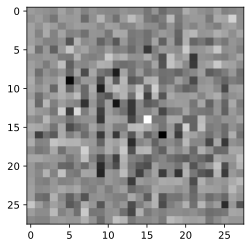

In [10]:
# Example

generator = make_generator_model()
generator.summary()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
# Discriminator

def make_discriminator_model():
    """Using the Keras-API and Tensorlfow as Backend to define a discriminator model for the GAN"""
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    """Generates a metric which tells 
    the sucess of the discriminator in respect too the generator.
    
    Keyword arguments:
    real_input -- sample batch of the training data
    fake_output -- sample of generated images
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    """Generates a metric which tells the 
    sucess of the generator in respect too the discriminator.
    
    Keyword arguments:    
    fake_output -- sample of generated images
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
"""Define a function which defines the training step within each epoch.
    
    Keyword arguments:    
    images -- training samples of the MNIST dataset
"""

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return ([gen_loss,disc_loss])

In [ ]:
def train(dataset, epochs):
    """Ddefine a method which actually starts the training, saves and generate images for the dcgan model.
    
    Keyword arguments:    
    dataset -- the prepared dataset which shall be sampled from
    epochs -- The defined hyperparameter epoch
    """
    
    loss_values = []
    for epoch in range(epochs):
        start = time.time()
        
        for i,image_batch in enumerate(dataset):
            loss_value_pair =train_step(image_batch)
            if i % 20 == 0:
                image_grid = generate_mnist_image_grid_for_dcgan(generator,title="Epoch {0}, iteration {1}".format(epoch,i))                
                save_generated_image(image_grid, epoch, i, "./images/dcgan/generated_mnist_images_per_iteration")
                
        # Save a generated image for every epoch
        image_grid = generate_mnist_image_grid_for_dcgan(generator,title="Epoch {0}, iteration {1}".format(epoch,i))                
        save_generated_image(image_grid, epoch, i, "./images/dcgan/generated_mnist_images_per_epoch")
        
        # Save the model every 10 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))         
        loss_values.append(loss_value_pair)
    images_for_adcanced_evaluation = get_images_for_advanced_evaluation(generator,100)
    print(images_for_adcanced_evaluation.shape)
    np.save("./images/dcgan/images_for_advanced_evaluation",images_for_adcanced_evaluation)
    return loss_values

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# Training Execution

loss_values = train(train_dataset, epochs)

In [ ]:
len(loss_values)

Restore the latest checkpoint.

In [ ]:
# Reload if sth. disapperas

images_for_advanced_evaluation_dcgan = np.load("./images/dcgan/images_for_advanced_evaluation_by_dcgan.npy")

In [ ]:
# Validation

img = tf.keras.preprocessing.image.array_to_img(images_for_advanced_evaluation_dcgan[0])
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

<a name='3.2'></a>

### 3.2. Conditional Deep Convolutional Generative Adversarial Networks

In [ ]:
def generator_model():
    """Using the Keras-API and Tensorlfow as Backend to define a Generator model for the cDCGAN"""
    # Prepare noise input
    input_z = tf.keras.layers.Input((100,))
    dense_z_1 = tf.keras.layers.Dense(1024)(input_z)
    act_z_1 = ACTIVATION(dense_z_1)
    dense_z_2 = tf.keras.layers.Dense(128 * 7 * 7)(act_z_1)
    bn_z_1 = tf.keras.layers.BatchNormalization()(dense_z_2)
    reshape_z = tf.keras.layers.Reshape((7, 7, 128), input_shape=(128 * 7 * 7,))(bn_z_1)

    # Prepare Conditional (label) input
    input_c = tf.keras.layers.Input((100,))
    dense_c_1 = tf.keras.layers.Dense(1024)(input_c)
    act_c_1 = ACTIVATION(dense_c_1)
    dense_c_2 = tf.keras.layers.Dense(128 * 7 * 7)(act_c_1)
    bn_c_1 = tf.keras.layers.BatchNormalization()(dense_c_2)
    reshape_c = tf.keras.layers.Reshape((7, 7, 128), input_shape=(128 * 7 * 7,))(bn_c_1)

    # Combine input source
    concat_z_c = tf.keras.layers.Concatenate()([reshape_z, reshape_c])

    # Image generation with the concatenated inputs
    up_1 = tf.keras.layers.UpSampling2D(size=(2, 2))(concat_z_c)
    conv_1 = tf.keras.layers.Conv2D(64, (5, 5), padding='same')(up_1)
    act_1 = ACTIVATION(conv_1)
    up_2 = tf.keras.layers.UpSampling2D(size=(2, 2))(act_1)
    conv_2 = tf.keras.layers.Conv2D(1, (5, 5), padding='same')(up_2)
    act_2 = tf.keras.layers.Activation("tanh")(conv_2)
    model = tf.keras.Model(inputs=[input_z, input_c], outputs=act_2)
    return model

In [ ]:
print("Generator:")
G = generator_model()
G.summary()

In [ ]:
def discriminator_model():
    """Using the Keras-API and Tensorlfow as Backend to define a Discriminatoer model for the cDCGAN"""
    input_gen_image = tf.keras.layers.Input((28, 28, 1))
    conv_1_image = tf.keras.layers.Conv2D(64, (5, 5), padding='same')(input_gen_image)
    act_1_image = ACTIVATION(conv_1_image)
    pool_1_image = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(act_1_image)
    conv_2_image = tf.keras.layers.Conv2D(128, (5, 5))(pool_1_image)
    act_2_image = ACTIVATION(conv_2_image)
    pool_2_image = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(act_2_image)

    input_c = tf.keras.layers.Input((100,))
    dense_1_c = tf.keras.layers.Dense(1024)(input_c)
    act_1_c = ACTIVATION(dense_1_c)
    dense_2_c = tf.keras.layers.Dense(5 * 5 * 128)(act_1_c)
    bn_c = tf.keras.layers.BatchNormalization()(dense_2_c)
    reshaped_c = tf.keras.layers.Reshape((5, 5, 128))(bn_c)

    concat = tf.keras.layers.Concatenate()([pool_2_image, reshaped_c])

    flat = tf.keras.layers.Flatten()(concat)
    dense_1 = tf.keras.layers.Dense(1024)(flat)
    act_1 = ACTIVATION(dense_1)
    dense_2 = tf.keras.layers.Dense(1)(act_1)
    act_2 = tf.keras.layers.Activation('sigmoid')(dense_2)
    model = tf.keras.Model(inputs=[input_gen_image, input_c], outputs=act_2)
    return model

In [ ]:
print("Discriminator:")
D = discriminator_model()
D.summary()

In [ ]:
def generator_containing_discriminator(g, d):
    """ Using the Keras-API and Tensorlfow as Backend to define a cDCGAN architecutre for 
        a cDCGAN which contaions two models (i) generator and (ii) discriminator
    
    Keyword Arguments:
    g -- Generator model 
    d -- Discriminator model
    """
    
    input_z = tf.keras.layers.Input((100,))
    input_c = tf.keras.layers.Input((100,))
    gen_image = g([input_z, input_c])
    d.trainable = False
    is_real = d([gen_image, input_c])
    model = tf.keras.Model(inputs=[input_z, input_c], outputs=is_real)
    return model

In [ ]:
print("Combined:")
GD = generator_containing_discriminator(G, D)
GD.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

In [ ]:
def train(epochs):
     """Ddefine a method which actually starts the training, saves and generate images for the cDCGAN model.
    
    Keyword arguments:    
    epochs -- The defined hyperparameter epoch
    """
    iteration = 0

    nb_of_iterations_per_epoch = int(train_images.shape[0] / batch_size)

    print("Number of iterations per epoch: {0}".format(nb_of_iterations_per_epoch))

    for epoch in range(epochs):
        #pbar = tqdm(desc="Epoch: {0}".format(epoch), total=train_images.shape[0])

        g_losses_for_epoch = []
        d_losses_for_epoch = []

        for i in range(nb_of_iterations_per_epoch):
            noise = generate_noise((batch_size, 100))

            image_batch = train_images[i * batch_size:(i + 1) * batch_size]
            label_batch = train_labels[i * batch_size:(i + 1) * batch_size]        

            generated_images = G.predict([noise, label_batch], verbose=0)

            if i % 20 == 0:
                image_grid = generate_mnist_image_grid(G,
                                                                    title="Epoch {0}, iteration {1}".format(epoch,
                                                                                                            iteration))
                save_generated_image(image_grid, epoch, i, "./images/cdcgan/generated_mnist_images_per_iteration")
                #image_logger.log_images("generated_mnist_images_per_iteration", [image_grid], iteration)

            X = np.concatenate((image_batch, generated_images))
            y = [1] * batch_size + [0] * batch_size
            label_batches_for_discriminator = np.concatenate((label_batch, label_batch))
            y = np.array(y)        

            D_loss = D.train_on_batch([X, label_batches_for_discriminator], y)
            d_losses_for_epoch.append(D_loss)

            noise = generate_noise((batch_size, 100))
            D.trainable = False
            G_loss = GD.train_on_batch([noise, label_batch], [1] * batch_size)
            D.trainable = True
            g_losses_for_epoch.append(G_loss)        
            #pbar.update(batch_size)
            iteration += 1

        # Save a generated image for every epoch
        image_grid = generate_mnist_image_grid(G, title="Epoch {0}".format(epoch))
        save_generated_image(image_grid, epoch, 0, "./images/cdcgan/generated_mnist_images_per_epoch")    
        #pbar.close()        
        

    images_for_adcanced_evaluation = get_images_for_advanced_evaluation(G,100)
    print(images_for_adcanced_evaluation.shape)
    np.save("./images/cdcgan/images_for_advanced_evaluation",images_for_adcanced_evaluation)
    G.save_weights("./models/cdcgan/cdcgan_generators.h5")
    D.save_weights("./models/cdcgan/cdcgan_discriminator.h5")

In [ ]:
train(epochs)

In [ ]:
G.save_weights("./models/cdcgan/cdcgan_generators.h5")
D.save_weights("./models/cdcgan/cdcgan_discriminator.h5")

In [ ]:
images_for_advanced_evaluation_cdcgan = get_images_for_advanced_evaluation_cdcgan(G,100)
print(images_for_adcanced_evaluation_cdcgan.shape)
np.save("./images/cdcgan/images_for_advanced_evaluation",images_for_adcanced_evaluation_cdcgan)

In [ ]:
img = tf.keras.preprocessing.image.array_to_img(images_for_adcanced_evaluation_cdcgan[0])
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

<a name='4'></a>

## 4. Evaluation

### 4.1. Visual Examination

 Use the generator model to get a set of images before training has started

In [ ]:
G = generator_model()
D = discriminator_model()

generated_images = []

for i in range(10):
    noise = generate_noise((10, 100))
    label_input = generate_condition_embedding(6, 10)
    gen_images = G.predict([noise, label_input], verbose=0)
    generated_images.extend(gen_images)

generated_images = np.array(generated_images)
image_grid = combine_images(generated_images)
image_grid = inverse_transform_images(image_grid)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(image_grid, cmap="gray")
#ax.set_title(title)
fig.canvas.draw()
plt.show()

Use the disciminator to predicted for the generated images whether the are  fake or not

In [ ]:
generated_images.shape
label_input = generate_condition_embedding(6, 100)

In [ ]:
prediction = D.predict([generated_images.reshape((100,28,28,1)), label_input.reshape((100,100))])
prediction.mean()

Use the trainned generator model to get a set of images before training has started

In [ ]:
G.load_weights("./models/cdcgan/cdcgan_generators.h5")
D.load_weights("./models/cdcgan/cdcgan_discriminator.h5")

In [ ]:
generated_images = []

for i in range(10):
    noise = generate_noise((10, 100))
    label_input = generate_condition_embedding(6, 10)
    gen_images = G.predict([noise, label_input], verbose=0)
    generated_images.extend(gen_images)

generated_images = np.array(generated_images)
print(generated_images.shape)
image_grid = combine_images(generated_images)
image_grid = inverse_transform_images(image_grid)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(image_grid, cmap="gray")
#ax.set_title(title)
fig.canvas.draw()
plt.show()

### Use the disciminator to predicted for the generated images whether the are  fake or not

In [ ]:
generated_images.shape
label_input = generate_condition_embedding(6, 100)
prediction = D.predict([generated_images.reshape((100,28,28,1)), label_input.reshape((100,100))])
prediction.mean()

<a name='4.2'></a>

### 4.2 K-Nearest-Neighbour (kNN)

Another  approach for  summarizing generator performance is “Nearest Neighbors.” This involves selecting examples of real images from the domain and locating one or more most similar generated images for comparison.

Distance measures, such as Euclidean distance between the image pixel data, is often used for selecting the most similar generated images.

The nearest neighbor approach is useful to give context for evaluating how realistic the generated images happen to be.

In [ ]:
fake_dcgan_images = images_for_advanced_evaluation_dcgan[[0,10,20,30,40,50,60,70,80,90]]
fake_cdcgan_images = generated_images[[0,10,20,30,40,50,60,70,80,90]]

real_images = train_images.reshape((train_images.shape[0],-1))

In [ ]:
nbrs = NearestNeighbors(n_neighbors=1, ).fit(real_images)

In [ ]:
distances, indices = nbrs.kneighbors(fake_dcgan_images.reshape((fake_dcgan_images.shape[0],-1)))

In [ ]:
neighbors_of_dcgan = train_images[indices.reshape(10)]
img = np.concatenate((fake_dcgan_images, neighbors_of_dcgan), axis=0)

# show imgs
fig = plt.figure(figsize=(40, 8))

title = ['DCGAN generated images', 'kNNs k=1','']

for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(img[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    if i == 14:
        title_index = 1
    elif i == 4:
        title_index = 0
    else:
        title_index = 2
    ax.set_title(title[title_index],fontweight ="bold",fontsize=30)

plt.savefig('DCGAN and KNN with k = 1')

In [ ]:
distances, indices = nbrs.kneighbors(fake_cdcgan_images.reshape((fake_cdcgan_images.shape[0],-1)))

In [ ]:
neighbors_of_cdcgan = train_images[indices.reshape(10)]
img = np.concatenate((fake_cdcgan_images, neighbors_of_cdcgan), axis=0)

# show imgs
fig = plt.figure(figsize=(40, 8))

title = ['cDCGAN generated images', 'Result kNN with k=1','']

for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(img[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    if i == 14:
        title_index = 1
    elif i == 4:
        title_index = 0
    else:
        title_index = 2
    ax.set_title(title[title_index],fontweight ="bold",fontsize=30)
    
plt.savefig('cDCGAN and KNN with k = 1')

<a name='4.3'></a>

### Fréchet Inception Distance (FID)

The Frechet Inception Distance, or FID, score was proposed and used by Martin Heusel, et al. in their 2017 paper titled “GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium.” The score was proposed as an improvement over the existing Inception Score.

>FID performs well in terms of discriminability, robustness and computational efficiency. […] It has been shown that FID is consistent with human judgments and is more robust to noise than IS — [Pros and Cons of GAN Evaluation Measures, 2018](https://arxiv.org/pdf/1802.03446.pdf).

Like the inception score, the FID score uses the inception v3 model. Specifically, the coding layer of the model (the last pooling layer prior to the output classification of images) is used to capture computer vision specific features of an input image. These activations are calculated for a collection of real and generated images.

In [ ]:
generated_images_cdcgan = []

for i in range(10):
    noise = generate_noise((100, 100))
    label_input = generate_condition_embedding(i, 100)
    gen_images = G.predict([noise, label_input], verbose=0)
    generated_images_cdcgan.extend(gen_images)

generated_images_cdcgan = np.array(generated_images)
print(generated_images_cdcgan.shape)
image_grid = combine_images(generated_images_cdcgan)
image_grid = inverse_transform_images(image_grid)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(image_grid, cmap="gray")
#ax.set_title(title)
fig.canvas.draw()
plt.show()

In [ ]:
generated_images_dcgan = np.load("./images/dcgan/images_for_advanced_evaluation_by_dcgan.npy")

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

In [ ]:
# Importing the required Keras modules containing model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(x=x_train,y=y_train, epochs=10)

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
image_index = 4444
#plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')

print(x_test.shape)
pred = model.predict(x_test)
print(pred.shape)
print(pred.argmax())

In [ ]:
real_images = x_train[np.random.choice(x_train.shape[0], 1000, replace=False), :]

In [ ]:
def calculate_fid(model, real_images, generated_images):    
    """Uses the Keras-API and the Tensorflow backend to generat the so-called FID score.
    
    Keyword arguments:    
    model-- Any binary classifier which can distinguish between two images
    real_images -- images sampled from the training dataset
    generated_images -- images sampled from the set of GAN generated_images
    """
    
    # calculate activations
    act1 = model.predict(real_images)
    act2 = model.predict(generated_images)

    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # calculate 8 of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))

    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

    # calculate fid
fid = calculate_fid(model, real_images, real_images)
print('Baseline FID score from real to real images: %.2f' % abs(fid))
fid = calculate_fid(model, real_images, fake_dcgan_images)
print('FID scroe from real and DCGAN generated images: %.2f' % fid)
fid = calculate_fid(model, real_images, generated_images_cdcgan)
print('FID scroe from real and cDCGAN generated images: %.2f' % fid)